# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Загрузка и первичный анализ

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:
data_reg = []
data_reg.append(pd.read_csv("/datasets/geo_data_0.csv"))
data_reg.append(pd.read_csv("/datasets/geo_data_1.csv"))
data_reg.append(pd.read_csv("/datasets/geo_data_2.csv"))

In [3]:
data_reg[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
data_reg[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
data_reg[2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
data_reg[0].describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [7]:
data_reg[1].describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [8]:
data_reg[2].describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Все столбцы с данными имеют тип float, поэтому мы легко можем посмотреть на корреляции между ними, плюс у нас есть лишний столбец 'id', так как индекс у нас есть свой.

### Предобработка данных

In [9]:
for i in range(len(data_reg)):
    data_reg[i] = data_reg[i].drop('id', axis = 1)

Убрали лишний столбец идентификатора, чтобы модель не смогла "запомнить" правильные ответы по идентификатору.

In [10]:
for i in range(len(data_reg)):
    print(data_reg[i].duplicated().sum())

0
0
0


Дубликатов нет. Отлично!

               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000


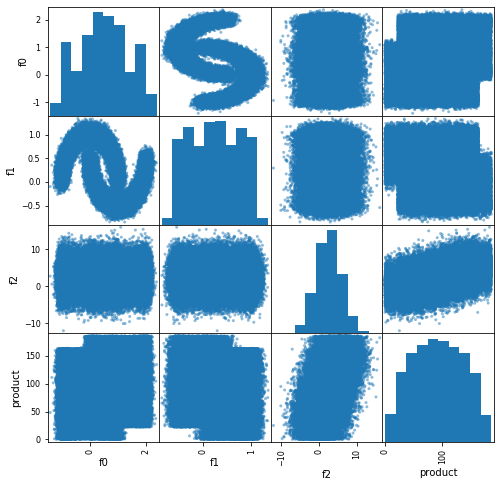

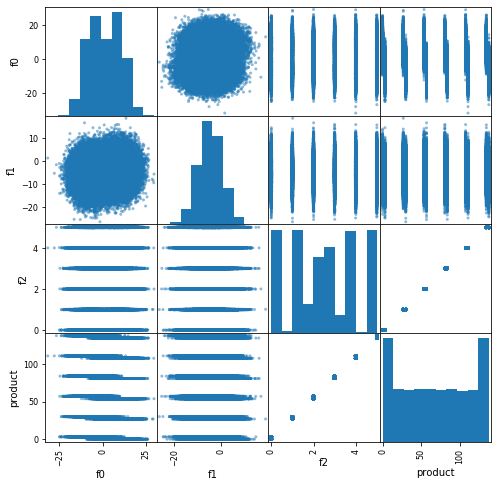

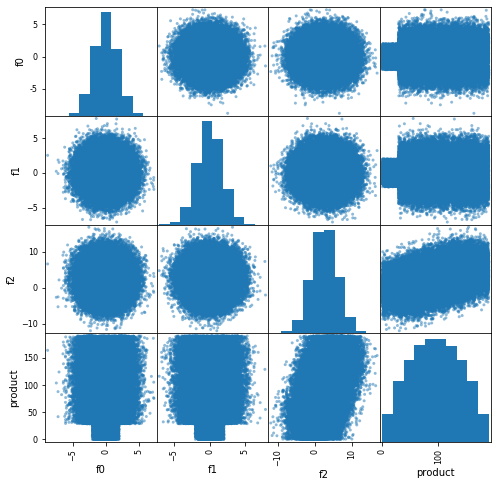

In [11]:
for reg in data_reg:
    print(reg.corr())
    pd.plotting.scatter_matrix(reg, figsize = (8,8))
    pass

Посмотрев на скаттерплоты из трёх регионов видим, что: в первом регионе есть нелинейная зависимость между f1 и f0, которая не определяется коэффициентом корреляции. Во втором регионе корреляция между f2 и количеством нефти практически равна 1, а это значит, что там f2 определяет колчесто нефти, что делает бессмысленным обучение, так как можно просто смотреть на данные f2 и делать выводы. В остальных регионах также прослеживается корреляция между f2 и product, однако не такая явная. 

### Фильтровка выбросов

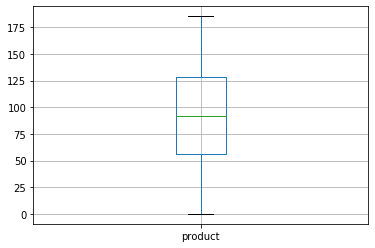

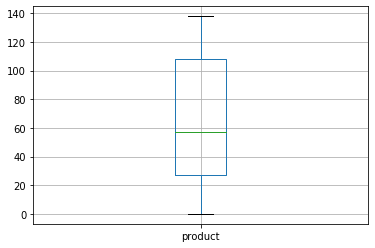

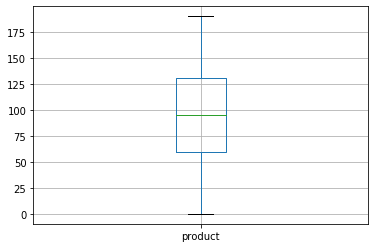

In [12]:
for i in range(len(data_reg)):
    data_reg[i][['product']].boxplot()
    plt.show()

***Вывод***

Выбросов нет.

### Разбиение на выборки

In [13]:
target = []
features = []
features_train_reg = []
features_valid_reg = []
target_train_reg = []
target_valid_reg = []

for i in range(len(data_reg)):
    target.append(data_reg[i]['product'])
    features.append(data_reg[i].drop('product', axis = 1))
    features_train, features_valid, target_train, target_valid = train_test_split(features[i], target[i], test_size = .25, random_state = 12345)
    
    features_train = features_train.reset_index(drop = True)
    target_train = target_train.reset_index(drop = True)
    features_valid = features_valid.reset_index(drop = True)
    target_valid = target_valid.reset_index(drop = True)
    
    features_train_reg.append(features_train)
    features_valid_reg.append(features_valid)
    target_train_reg.append(target_train)
    target_valid_reg.append(target_valid)
    
    print("Размеры обучающей выборки", str(i+1) +'-го региона:', len(features_train), len(target_train))
    print("Размеры валидной выборки", str(i+1) +'-го региона:', len(features_valid), len(target_valid))



Размеры обучающей выборки 1-го региона: 75000 75000
Размеры валидной выборки 1-го региона: 25000 25000
Размеры обучающей выборки 2-го региона: 75000 75000
Размеры валидной выборки 2-го региона: 25000 25000
Размеры обучающей выборки 3-го региона: 75000 75000
Размеры валидной выборки 3-го региона: 25000 25000


### Масштабирование признаков

In [14]:
scaler = StandardScaler()


for i in range(len(data_reg)):
    scaler.fit(features_train_reg[i])
    features_train_reg[i] = scaler.transform(features_train_reg[i])
    features_valid_reg[i] = scaler.transform(features_valid_reg[i])

## Обучение и проверка модели

### Модель линейной регрессии

In [15]:
model = LinearRegression()
models_reg = []
for i in range(len(data_reg)):
    model.fit(features_train_reg[i], target_train_reg[i])
    models_reg.append(model)
    predicted_valid = model.predict(features_valid_reg[i])
    mse = mean_squared_error(target_valid_reg[i], predicted_valid)
    print("RMSE и средний предсказанный запас:", round(mse**0.5, 2),"и", round(predicted_valid.mean(), 2))

RMSE и средний предсказанный запас: 37.58 и 92.59
RMSE и средний предсказанный запас: 0.89 и 68.73
RMSE и средний предсказанный запас: 40.03 и 94.97


### Модель линейной регрессии с использованием градиентного спуска

In [16]:
model = SGDRegressor()
for i in range(len(data_reg)):
    model.fit(features_train_reg[i], target_train_reg[i])
    predicted_valid = model.predict(features_valid_reg[i])
    mse = mean_squared_error(target_valid_reg[i], predicted_valid)
    print("RMSE и средний предсказанный запас:", round(mse**0.5, 2),"и", round(predicted_valid.mean(), 2))

RMSE и средний предсказанный запас: 37.6 и 91.46
RMSE и средний предсказанный запас: 0.89 и 68.74
RMSE и средний предсказанный запас: 40.03 и 94.65


### Модель линейной регрессии с поиском зависимостей n-го порядка

In [17]:
model = LinearRegression()
for i in range(1, 6):
    poly = PolynomialFeatures(i, include_bias=False)
    for j in range(len(data_reg)):
        
        poly_features_train = poly.fit_transform(features_train_reg[j]) 

        poly_features_valid = poly.fit_transform(features_valid_reg[j]) 
        poly_features_valid = scaler.fit_transform(poly_features_valid)

        model.fit(poly_features_train, target_train_reg[j])

        predicted_valid = model.predict(poly_features_valid) 
        mse = mean_squared_error(target_valid, predicted_valid) 
        print("RMSE и средний предсказанный запас для", str(j+1) +'-ого региона', str(i)+"-ой степени:", round(mse**0.5, 2),"и", round(predicted_valid.mean(), 2))

RMSE и средний предсказанный запас для 1-ого региона 1-ой степени: 50.51 и 92.64
RMSE и средний предсказанный запас для 2-ого региона 1-ой степени: 69.15 и 68.86
RMSE и средний предсказанный запас для 3-ого региона 1-ой степени: 40.03 и 95.04
RMSE и средний предсказанный запас для 1-ого региона 2-ой степени: 50.52 и 92.42
RMSE и средний предсказанный запас для 2-ого региона 2-ой степени: 69.15 и 68.86
RMSE и средний предсказанный запас для 3-ого региона 2-ой степени: 40.07 и 85.05
RMSE и средний предсказанный запас для 1-ого региона 3-ой степени: 51.55 и 92.45
RMSE и средний предсказанный запас для 2-ого региона 3-ой степени: 69.16 и 68.86
RMSE и средний предсказанный запас для 3-ого региона 3-ой степени: 40.07 и 85.04
RMSE и средний предсказанный запас для 1-ого региона 4-ой степени: 51.54 и 93.11
RMSE и средний предсказанный запас для 2-ого региона 4-ой степени: 69.16 и 68.86
RMSE и средний предсказанный запас для 3-ого региона 4-ой степени: 42.17 и 78.35
RMSE и средний предсказанный

***Вывод***

При сравнении обычных моделей и моделей с использованием полиномиальных матриц видим, что полиномиальные матрицы не особо помогают в нашем случае, при их использовании также теряется очень точный прогноз для 2-го региона, полученный при использовании обычной линейной регрессии(RMSE < 1). Поэтому будем использовать обычную линейную регрессию.

## Подготовка к расчёту прибыли

In [18]:
TOTAL_WELLS = 500   #количество разведываемых скважин
WELLS_TO_USE = 200  #количество разрабатываемых скважин
BUDGET = 10000      #бюджет в миллионах
UNIT_PRICE = 0.45   #стоимость тысячи баррелей в миллионах

Сохранили значения

In [19]:
min_volume = 10000 / 200 / 0.45
print("Минимальный объём для безубыточности:", min_volume)
print("Средний запас в первом, втором и третьем регионах:", round(data_reg[0]['product'].mean(), 2), round(data_reg[1]['product'].mean(), 2), round(data_reg[2]['product'].mean(), 2))

Минимальный объём для безубыточности: 111.11111111111111
Средний запас в первом, втором и третьем регионах: 92.5 68.83 95.0


***Вывод***

Исходя из полученных данных в среднем, если бурить скважины наобум, то мы прогорим. Посмотрим, что нам даст модель.

### Функция расчёта прибыли и её проверка на обобщённых данных.

In [20]:
def expected_value(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target.reindex(probs_sorted.index)[:count]
    return UNIT_PRICE * selected.sum() - 10000

## Расчёт прибыли и рисков 

Используем бутсреп для модели, чтобы оценить среднюю выручку и 95%-ый доверительный интервал для каждого региона, а потом считаем вероятность убытков.

In [21]:
state = np.random.RandomState(12345)
print("Средняя выручка, 95%-ый доверительный интервал и вероятность убытков для 1, 2 и 3 регионов соответственно")
for j in range(len(data_reg)):
    values = []
    predictions_reg = pd.Series(models_reg[j].predict(features_valid_reg[j]))
    for i in range(1000):
        target_subsample = target_valid_reg[j].sample(n = TOTAL_WELLS, random_state = state)
        predictions_reg_subsample = predictions_reg[target_subsample.index]
        values.append(expected_value(target_subsample, predictions_reg_subsample, WELLS_TO_USE))
    values = pd.Series(values)
    print("Средняя прибыль:", values.mean())
    print("95%-ый доверительный итервал:", values.quantile(.025), values.quantile(.975))
    
    print("Вероятность убытков:", values[values.values < 0].count()/1000, "\n")

Средняя выручка, 95%-ый доверительный интервал и вероятность убытков для 1, 2 и 3 регионов соответственно
Средняя прибыль: 232.54114322893486
95%-ый доверительный итервал: -284.03660763165436 715.7194087713489
Вероятность убытков: 0.182 

Средняя прибыль: 427.03616100280215
95%-ый доверительный итервал: 15.292734099517475 821.6871359563802
Вероятность убытков: 0.021 

Средняя прибыль: 389.21707368557037
95%-ый доверительный итервал: -115.60956577767396 906.5125901730092
Вероятность убытков: 0.073 



***Вывод***

Наши модели дают на прибыль минимум в 80% случаев! Это явно больше, чем выбор наобум, так как мы посчитали, что в среднем мы прогораем. Выбор региона для бурения скорее всего стоит остановить на 2-ом регионе, так как там наименьший шанс убытков, и хоть максимальное значение доверительного интервала 3-его регона больше, чем 2-го. Среднее у 2-го всё-таки выше. И если мы хотим получать прибыль, то разрабатывая скважины 2-го региона мы в среднем будем получать больше. А это значит, что при разработке 2-го региона наименьшие риски и наибольшая прибыль. Поэтому скорее всего будет выгоднее разрабатывать скважины в регионе 2.